# Geospatial Analysis of the Flood Impacts on Landcover and Buildings in Maiduguri Nigeria for September 2024

#### Data Acquisition:
- Acquired Sentinel-2 data for September 2024 over Maiduguri. The script uses Google Earth Engine to search for the necessary data and the Data Space Browser to initially visualize the area.

- The code then downloads OpenStreetMap data for Maiduguri, including buildings information, using the osmnx library to query the OpenStreetMap API.

#### Data Processing:
- Sentinel-2 data is processed using googel earth engine ee and geemap to open the downloaded image and extract relevant bands.

- The NDWI is calculated, and a simple threshold is applied.

- OpenStreetMap data is processed to extract features (buildings and land use). The code then uses geopandas to create GeoDataFrames and reproject them to the same CRS as the Sentinel-2 data.

#### Analysis and Visualization:
- The code combines the Sentinel-2 and OpenStreetMap data.
- It calculates the flooded landcover area by intersecting the water mask with the landcover layer.
- It then visualizes the data using Matplotlib. The code creates a flood extent map, a crop impact map showing NDVI, and a vulnerability map using the flooded landcover ratio.

#### Output and Communication
... (Generate report, share data, and communicate findings) ...


In [2]:
# Import necessary libraries
import os
import datetime
import time
import requests
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap
import osmnx as ox
from shapely.geometry import Polygon, mapping, LineString, shape
import rasterio
import rioxarray
import xarray as xr
import zarr
import pystac
from pystac import Catalog
from pystac.extensions.projection import ProjectionExtension
import dask


In [3]:
# Better visualization
plt.style.use('ggplot')

In [6]:
# DATA_DIR = 'maiduguri_flood_archive'
# ZARR_STORE = os.path.join(DATA_DIR, 'maiduguri.zarr')

In [ ]:
# client = Client('127.0.0.1:8787')

In [5]:
# if not os.path.exists(DATA_DIR):
#     os.makedirs(DATA_DIR)
# else :
#     pass
#     # shutil.rmtree(DATA_DIR)
#     # os.makedirs(DATA_DIR)

In [6]:
# def log_progress(message): 
#     timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
#     now = datetime.now() # get current timestamp 
#     timestamp = now.strftime(timestamp_format) 
#     with open("./log/log.txt","a") as f: 
#         f.write(timestamp + ' : ' + message + '\n')

In [4]:
EE_PROJECT_ID = os.environ.get('EE_PROJECT_ID', "")


In [5]:
geemap.ee_initialize(project=EE_PROJECT_ID)

In [6]:
geojson_data = {"type":"Polygon","coordinates":[[[13.059998,11.836439],[13.318176,12.136005],[13.454132,12.035291],[13.242645,11.790736],[13.271484,11.757126],[13.233032,11.734269],[13.059998,11.836439]]]}
# Area = 810.87 km2
# Extract the coordinates
coordinates = geojson_data["coordinates"][0]

# Find the minimum and maximum longitude and latitude
min_lon = min([coord[0] for coord in coordinates])
max_lon = max([coord[0] for coord in coordinates])
min_lat = min([coord[1] for coord in coordinates])
max_lat = max([coord[1] for coord in coordinates])

# Construct the bounding box
bbox = [min_lon, min_lat, max_lon, max_lat]

print("bbox:", bbox)


bbox: [13.059998, 11.734269, 13.454132, 12.136005]


In [7]:
# Using ee.Geometry.Polygon
roi = ee.Geometry.Polygon(coordinates)
display(roi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              13.059998,
              11.836439
            ],
            [
              13.318176,
              12.136005
            ],
            [
              13.454132,
              12.035291
            ],
            [
              13.242645,
              11.790736
            ],
            [
              13.271484,
              11.757126
            ],
            [
              13.233032,
              11.734269
            ],
            [
              13.059998,
              11.836439
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [8]:
# Extract center coordinates
bbox_coords = geojson_data["coordinates"][0]
longitude = sum([coord[0] for coord in bbox_coords]) / len(bbox_coords)
latitude = sum([coord[1] for coord in bbox_coords]) / len(bbox_coords)
center = [latitude, longitude] 
display(center)

[11.875186428571428, 13.234209285714286]

In [ ]:
# ## 1. Data Acquisition

# **1.1 Download Sentinel-2 Data**

# # Create the STAC Catalog

# catalog = pystac.Catalog(
#     id="maiduguri-catalog",
#     title="Maiduguri Sentinel-2 Catalog",
#     description="STAC Catalog for Sentinel-2 Baseline Product in the Maiduguri Area.",
# )


In [ ]:
# # Function to parse ISO 8601 date strings with 'Z'
# def parse_iso_date(iso_date):
#     return datetime.strptime(iso_date.replace("Z", "+00:00"), "%Y-%m-%dT%H:%M:%S.%f%z")

# # Create a STAC Item for the product
# baseline_stac_item = pystac.Item(
#     id="S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE",
#     geometry={
#         "type": "Polygon",
#         "coordinates": [
#             [   
#                 [13.059998, 11.836439],
#                 [13.233032, 11.734269],
#                 [13.271484, 11.757126],
#                 [13.242645, 11.790736],
#                 [13.454132, 12.035291],
#                 [13.318176, 12.136005],
#                 [13.059998, 11.836439]
#             ]
#         ]
#     },
#     bbox=(13.059998, 11.734269, 13.454132, 12.136005),
#     datetime=parse_iso_date(""),
#     properties={
#         "platform": "SENTINEL-2",
#         "cloud_coverage": int,
#         "beginning_datetime": "",
#         "ending_datetime": "",
#         "absolute_orbit": 17779,
#         "instrument": "MSI",
#         "acquisition_mode": "INS-NOBS",
#         "processing_level": "S2MSI2A",
#         "tile_id": "33MTR",
#         "spatial_resolution": 60.0,
#         "published": "",
#         "size": "< 1MB",
#         "product_id": "https://zipper.dataspace.copernicus.eu/odata/v1/Products()/$value",
#         "download_link": "https://link.dataspace.copernicus.eu/yxsh"
#     }
# )

# # Use S3 path as the asset href
# baseline_stac_item.add_asset(
#         key="data",
#         asset=pystac.Asset(
#             href="/eodata/Sentinel-2/MSI/L2A/2018/11/17/S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE",
#             media_type=pystac.MediaType.GEOTIFF,
#             title="Sentinel-2 S3 Data"
#         )
#     )
# baseline_stac_item.add_asset(
#     key="BaseB03",
#     asset=pystac.Asset(
#         href="./Browser_images/SENTINEL-2/Baseline/2018-07-31-00_00_2023-07-30-23_59_Sentinel-2_L2A_B03_(Raw).tiff",
#         media_type=pystac.MediaType.TIFF,
#         title="Sentinel-2 Baseline B03"
#     )
# )

# baseline_stac_item.add_asset(
#     key="BaseB04",
#     asset=pystac.Asset(
#         href="./Browser_images/SENTINEL-2/Baseline/2018-07-31-00_00_2023-07-30-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
#         media_type=pystac.MediaType.TIFF,
#         title="Sentinel-2 Baseline B04"
#     )
# )

# baseline_stac_item.add_asset(
#     key="BaseB08",
#     asset=pystac.Asset(
#         href="./Browser_images/SENTINEL-2/Baseline/2018-07-31-00_00_2023-07-30-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
#         media_type=pystac.MediaType.TIFF,
#         title="Sentinel-2 Baseline B08"
#     )
# )



In [ ]:
# # Add the item to the catalog
# catalog.add_item(baseline_stac_item)

# # Create a directory for the STAC catalog if it doesn't exist
# output_directory = './stac_catalog'
# os.makedirs(output_directory, exist_ok=True)

# # Get the current date and time
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# # Create the output file path with datetime
# output_file_path = os.path.join(output_directory, f'baseline_catalog-{current_datetime}')

# # Normalize hrefs and save the STAC catalog to a file
# catalog.normalize_hrefs(output_directory)
# catalog.save(catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED, dest_href=output_file_path)

# print(f"STAC catalog saved to {output_file_path}")

# print("STAC Item created:")

# display(baseline_stac_item.to_dict())

# log_progress('Baseline stac creation complete. Initiating process_baseline_analysis')


In [15]:
# Load Sentinel-2 image collection
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

In [16]:
# Filter the collection for time range for image during the flood
start_date = '2024-08-14'
end_date = '2024-09-14'
s2_Image_flood = s2_collection.filterDate(start_date, end_date).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 50).filterBounds(roi)

In [17]:
s2_Image_flood = s2_Image_flood.mosaic().clip(roi)

In [18]:
# Create an interactive map
Map1 = geemap.Map(center=center, zoom = 12)
Map1.add_basemap("ROADMAP")

In [13]:
# Visualize the image during the flood
s2_Viz = {"min":0.0, "max":3000, "bands":["B4", "B3", "B2"]}
Map1.addLayer(s2_Image_flood, s2_Viz, "s2_Image_flood")
Map1
#Map.centerObject(s2_Image_flood, 8)

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [19]:
tile_id = s2_collection.get('MGRS_TILE').getInfo()

In [20]:
# Load Pre_flood images
 
start_date = '2024-06-01'
end_date = '2024-06-30'
s2_Collection_pre = s2_collection.filterDate(start_date, end_date).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 50).filterBounds(roi).getInfo()

display(s2_Collection_pre)

{'type': 'ImageCollection',
 'bands': [],
 'version': 1727814171102774,
 'id': 'COPERNICUS/S2_SR_HARMONIZED',
 'properties': {'date_range': [1490659200000, 1647907200000],
  'period': 0,
  'system:visualization_0_min': '0.0',
  'type_name': 'ImageCollection',
  'keywords': ['copernicus',
   'esa',
   'eu',
   'msi',
   'reflectance',
   'sentinel',
   'sr'],
  'system:visualization_0_bands': 'B4,B3,B2',
  'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png',
  'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands 

In [21]:
# tiles = ["33PUN","33PUP","33PTN",]
# .filter(ee.Filter.inList("MGRS_TILE", tiles))

s2_Collection_pre = s2_collection.filterDate(start_date, end_date).filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 50).filterBounds(roi)


In [14]:
# Check the numbers of image in the collection
print("The number of available images before flood is:", s2_Collection_pre.size().getInfo())

The number of available images before flood is: 8


In [22]:
# Create a mosaic from the s2_Collection_Pre

s2_Image_pre = s2_Collection_pre.mosaic().clip(roi)

In [19]:
# Visualize the image before the flood
Map2 = geemap.Map(center=center, zoom = 12)
Map2.addLayer(s2_Image_pre, s2_Viz, "s2_Image_pre")
Map2

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [23]:
# Calculate NDVI
ndvi = s2_Image_flood.normalizedDifference(['B8', 'B4'])

## Flood Extent Mapping Using MNDWI

In [16]:
# Compute the MNDWI before flood
s2_Mndwi_pre = s2_Image_pre.normalizedDifference(["B3", "B8"]).rename("MNDWI")

In [21]:
# Visualize the MNDWI before flood
mndwi_Viz = {min:0.01, max:0.8, "palette":["#f7fbff", "#1452d9"]}

Map3 = geemap.Map(center=center, zoom = 13)
Map3.addLayer(s2_Mndwi_pre, mndwi_Viz)
Map3

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
# Compute the MNDWI during flood
s2_Mndwi_flood = s2_Image_flood.normalizedDifference(["B3","B8"]).rename("MNDWI")
s2_Mndwi_flood = s2_Mndwi_flood.select("MNDWI")

In [23]:
# Visualize the MNDWI after flood
Map4 = geemap.Map(center=center, zoom = 12)

Map4.addLayer(s2_Mndwi_flood, mndwi_Viz)
Map4

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [18]:
# Define a function that accepts an MNDWI layer and threshold value and return a mask layer
def water_mask(layer, threshold):
    mask = layer.gt(threshold).rename("water_mask").selfMask()
    return mask


In [19]:
# Extract permanent water body from the s2_mndwi_pre
perm_water = water_mask(s2_Mndwi_pre, 0)

In [20]:
# Extract flooded extent PLUS permanent water body from the s2_Mndwi_flood
flood_water = water_mask(s2_Mndwi_flood, 0)

In [21]:
# Mask out Permanent water bodies to get JUST the flood extent

# First Create a mask for the non permanent water
notPermWaterMask = s2_Mndwi_pre.lt(0).selfMask()

# Extract the flooded extent only
flooded = flood_water.updateMask(notPermWaterMask)

In [22]:
# Smooth the flooded extent layer to get a refined 
threshold = 6
connection = flooded.connectedPixelCount(26)
flooded = flooded.updateMask(connection.gt(threshold))

In [36]:
# Visualize the permanent water body overlaid on the flood layer
water_Viz = {min:0.0, max:0.9, "palette": ["#f7fbff", "#71c5f6"]}

Map5 = geemap.Map(center=center, zoom = 13)
Map5.addLayer(flooded, {min: 0.0, max:0.9, "palette": ["blue"]},"flooded")
Map5

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [23]:
# Convert the binary image to integer with values 0 and 1
flooded_int = flooded.multiply(255).toInt()

## Flood Damage Assessment

In [27]:
# Load and visualize the ESA land cover data
esa_LC = ee.ImageCollection('ESA/WorldCover/v200').first().clip(roi)

vis_lc = {"bands": ['Map']}

Map6 = geemap.Map(center=center, zoom = 11)
Map6.addLayer(esa_LC, vis_lc, 'Landcover')
Map6

Map(center=[11.875186428571428, 13.234209285714286], controls=(WidgetControl(options=['position', 'transparent…

In [47]:
# Create a function that export a GEE layer to GTiff 

def gee_to_tiff(input_layer, out_folder, output_filename):
    
    try:
        if not os.path.exists(out_folder):
            os.mkdir(out_folder)
        file_name = os.path.join(out_folder, output_filename)
        
        # Export a GEE layer to raster Gtiff
        raster = geemap.ee_export_image(
            input_layer,
            file_name,
            scale = 10,
            region = roi,
            crs= "EPSG:32737",
            file_per_band = False
        )
        return raster
    except Exception as e:
        print("An erro has occurred:", e)

In [48]:
# Export the land cover layer as a tiff file
gee_to_tiff(esa_LC, "outputs", "landcover.tif")

Generating URL ...
Please wait ...
Data downloaded to c:\Users\HP\Downloads\Cloud\00-analytics-ready\Geospatial Information System Research and Design\projects\geospatial_analysis_flood_impacts_on_crops_in_maiduguri_nigeria\outputs\landcover.tif


In [ ]:
# catalog_path = 'stac_catalog/baseline_catalog-20240910_154345/catalog.json'
# catalog = pystac.Catalog.from_file(catalog_path)

# print(f"Catalog ID: {catalog.id}")

In [ ]:
# items = list(catalog.get_items()) 
# print(f"Number of items: {len(items)}")

# # Get the list of items
# items = list(catalog.get_items())

# # Print out the available item IDs
# for item in items:
#     print(item.id) 

In [ ]:


# # Replace with the actual item ID you want to access
# item_id = 'S2A_MSIL2A_20181117T091241_N0213_R050_T33MTR_20201129T230722.SAFE'  # Adjust as needed
# baseline_stac_item = catalog.get_item(item_id)

# display(baseline_stac_item)


In [49]:
# Create a function that converts a GEE raster layer to vector and dissolve the vector
    
def raster_to_vector(input_layer, out_folder, output_shp):

    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
        
    file_name = os.path.join(out_folder, output_shp)
    #output_file = os.path.join(out_folder, output_shp)

    # Convert raster to vector
    vector = input_layer.reduceToVectors(
        geometry= roi,
        crs= "EPSG:32737",
        scale= 10,
        geometryType='polygon',
        bestEffort=True,
        maxPixels=1e8,
        #tileScale=4
    )
    
    # convert the ee vector to shapefile and read to gdf 
    geemap.ee_to_shp(vector, file_name) 
    shp = gpd.read_file(file_name)

    # Dissolve the shapefile
    print("Attributes in the shapefile:", shp.columns) # Check for the column to dissolve
    shp_dv = shp.dissolve(by="label") # You may need to change the "label" argument depending on the attributes in your input
    shp_dv = shp_dv.to_crs("EPSG:32737")
    
    # Add Area attribute to the dissolved shapefile
    shp_dv["Area_km2"] = (shp_dv.geometry.area) / 1e6 
    print(shp_dv.crs) 
    
    # Export the shapefile
    output_shp = shp_dv.to_file(file_name, driver='ESRI Shapefile')

    return output_shp

In [52]:
# Convert the flooded extent from raster to vector
raster_to_vector(flooded_int, "outputs", "flood_dv.shp")

Attributes in the shapefile: Index(['count', 'label', 'geometry'], dtype='object')
EPSG:32737


In [53]:
# Convert the land cover from raster to vector
raster_to_vector(esa_LC, "outputs", "lc_dv.shp")

Attributes in the shapefile: Index(['count', 'label', 'geometry'], dtype='object')
EPSG:32737


In [28]:
# Land cover attribute information
lc_bands = {
    10: "Tree cover", 
    20: "Shrubland", 
    30: "Grassland", 
    40: "Cropland", 
    50: "Built-up", 
    60: "Bare / Sparse Vegetation", 
    90: "Mangroves" 
} 

In [29]:
# Write a function to determine the exent of land cover affected by the flood
def landcover_damage(flood_shp, lc_shp, output_shp):

    out_folder = "Outputs"
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    flood_extent = os.path.join(out_folder, flood_shp)
    lc_extent = os.path.join(out_folder, lc_shp)
    output_file = os.path.join(out_folder, output_shp)

    # Load the flooded shapefile and the land cover shapefile
    gdf_flood = gpd.read_file(flood_extent)
    gdf_lc = gpd.read_file(lc_extent)
    
    # Perform intersection operation to determine the affected land cover
    affected_lc = gpd.overlay(gdf_flood, gdf_lc, how= "intersection", keep_geom_type=True)
    print(affected_lc.columns)
    
    # Drop and rename columns
    affected_lc.drop(columns=["label_1", "count_1", "Area_km2_1", "count_2", "Area_km2_2"], inplace = True)
    affected_lc.rename(columns={"label_2": "label",}, inplace = True) 

    # Remove permanent water bodies
    affected_lc.drop(affected_lc[affected_lc['label'] == 80].index, inplace=True)

    # Add the class column based on the label / map the name of the land covers 
    affected_lc['class'] = affected_lc['label'].map(lc_bands)

    # Re-compute the areas
    affected_lc["Area_km2"] = ((affected_lc.geometry.area) / 1e6).round(3)
    print(affected_lc.head())

    # Export the shapefiles of affected land cover
    affected_lc_shp = affected_lc.to_file(output_file, driver='ESRI Shapefile')

    return affected_lc_shp



In [30]:
# Determine the affected land cover
landcover_damage("flood_dv.shp", "lc_dv.shp", "affected_lc_dv.shp")

Index(['label_1', 'count_1', 'Area_km2_1', 'label_2', 'count_2', 'Area_km2_2',
       'geometry'],
      dtype='object')
   label                                           geometry       class  \
0     10  MULTIPOLYGON (((-2409668.197 11445865.486, -24...  Tree cover   
1     20  MULTIPOLYGON (((-2403119.155 11443565.354, -24...   Shrubland   
2     30  MULTIPOLYGON (((-2407158.622 11443605.431, -24...   Grassland   
3     40  MULTIPOLYGON (((-2407188.617 11443615.431, -24...    Cropland   
4     50  MULTIPOLYGON (((-2410818.029 11446215.509, -24...    Built-up   

   Area_km2  
0     1.525  
1     2.530  
2    89.982  
3   100.744  
4    18.146  


## Visualize the Results of the Damage Assessment

In [25]:
# Read the affected land cover files into GeodataFrames

affected_lc = gpd.read_file("outputs/affected_lc_dv.shp")

In [33]:
# Inspect the affected land cover
affected_lc.info()
affected_lc.head(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   label     7 non-null      int64   
 1   class     7 non-null      object  
 2   Area_km2  7 non-null      float64 
 3   geometry  7 non-null      geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 352.0+ bytes


,label,class,Area_km2,geometry
0,10,Tree cover,1.525,"MULTIPOLYGON (((-2409668.197 11445865.486, -24..."
1,20,Shrubland,2.530,"MULTIPOLYGON (((-2403119.155 11443565.354, -24..."
2,30,Grassland,89.982,"MULTIPOLYGON (((-2407158.622 11443605.431, -24..."
3,40,Cropland,100.744,"MULTIPOLYGON (((-2407188.617 11443615.431, -24..."
4,50,Built-up,18.146,"MULTIPOLYGON (((-2410818.029 11446215.509, -24..."
5,60,Bare / Sparse Vegetation,2.125,"MULTIPOLYGON (((-2409948.184 11445245.489, -24..."
6,90,Mangroves,1.021,"MULTIPOLYGON (((-2397000.144 11438525.225, -23..."


In [34]:
# Visualize the affected land cover types

# Define the color map for the classes
lc_bands_colors = {
    "Tree cover": "#006400",
    "Shrubland": "#ffbb22",
    "Grassland": "#fae500",
    "Cropland": "#ad89dd",
    "Built-up": "#e31a1c",
    "Bare / Sparse Vegetation": "#d4dadc",
    "Mangroves": "#1ec61e"
}

# Function to style each feature based on the class
def style_function(feature):
    return {
        'fillColor': lc_bands_colors.get(feature['properties']['class'], 'black'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6,
    }

# Initialize a geemap map
m = geemap.Map()

# Add GeoDataFrame to the map using add_gdf with style_callback
m.add_gdf(
    affected_lc,
    layer_name="Affected Land Cover",
    style={},
    hover_style={'fillOpacity': 0.8},
    style_callback=style_function,
    info_mode="on_hover",
    zoom_to_layer=True
)

# Display the map
m


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

<Axes: >

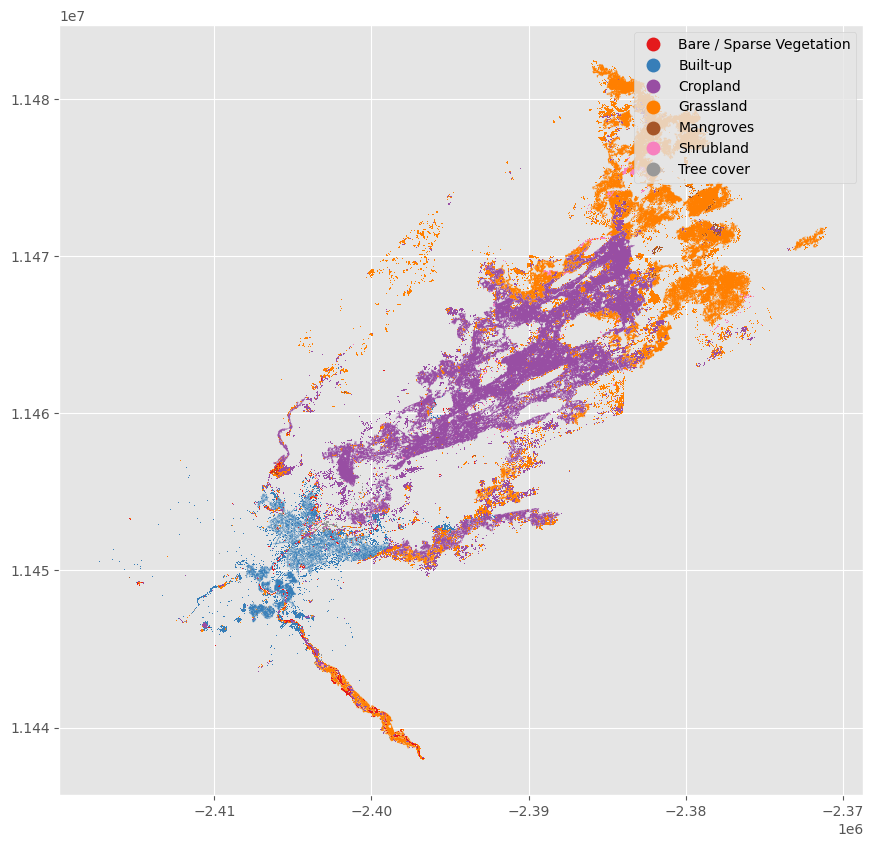

In [35]:
fig, ax = plt.subplots(1, figsize=(15, 10))

# Visualize the affected land cover types
affected_lc.plot(
    "class", 
    legend=True,
    cmap ="Set1",
    ax=ax    
)

Text(0.5, 1.0, 'Affected Land Cover Area by Flooding along Tana River')

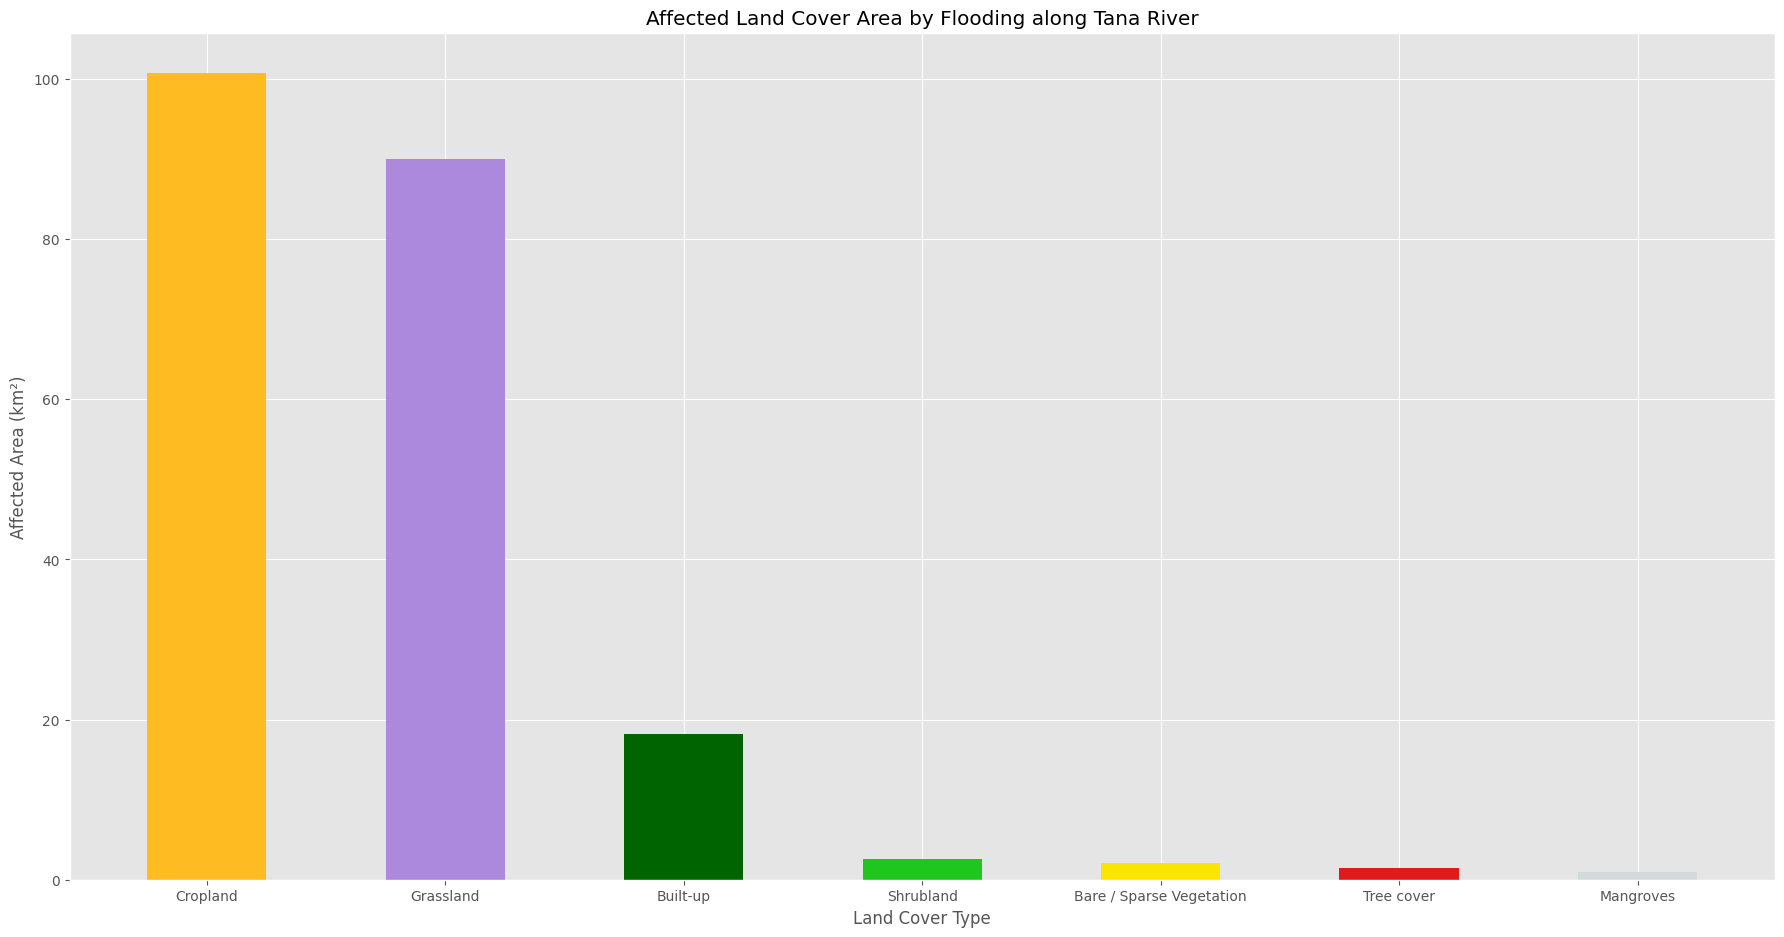

In [36]:
# Create a bar chart to see the area affected for each land cover class

# List of colors for the bars based on the order of Area_km2
colors = ["#ffbb22", "#ad89dd", "#006400", "#1ec61e", "#fae500", "#e31a1c", "#d4dadc"]

# Ensure that the number of colors is equal to the number of land cover classes
if len(colors) < affected_lc.shape[0]:
    raise ValueError("Not enough colors for the number of land cover classes.")

# Sort the DataFrame by 'Area_km2' in descending order
affected_lc_sorted = affected_lc.sort_values(by='Area_km2', ascending=False)

fig, ax = plt.subplots(1, figsize=(22, 11))

# Plot the bars with different colors
ax.bar(affected_lc_sorted["class"], affected_lc_sorted["Area_km2"], color=colors[:affected_lc.shape[0]], width=0.5)

# Add labels and title
plt.xlabel("Land Cover Type")
plt.ylabel("Affected Area (km²)")
plt.title("Affected Land Cover Area by Flooding along Tana River")